In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset_path = pd.read_csv("/content/DataSet/winequality-red.csv")
print("Dataset Sample: ")
dataset_path.head()

Dataset Sample: 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
print("Dataset Shape: ", dataset_path.shape)

Dataset Shape:  (1599, 12)


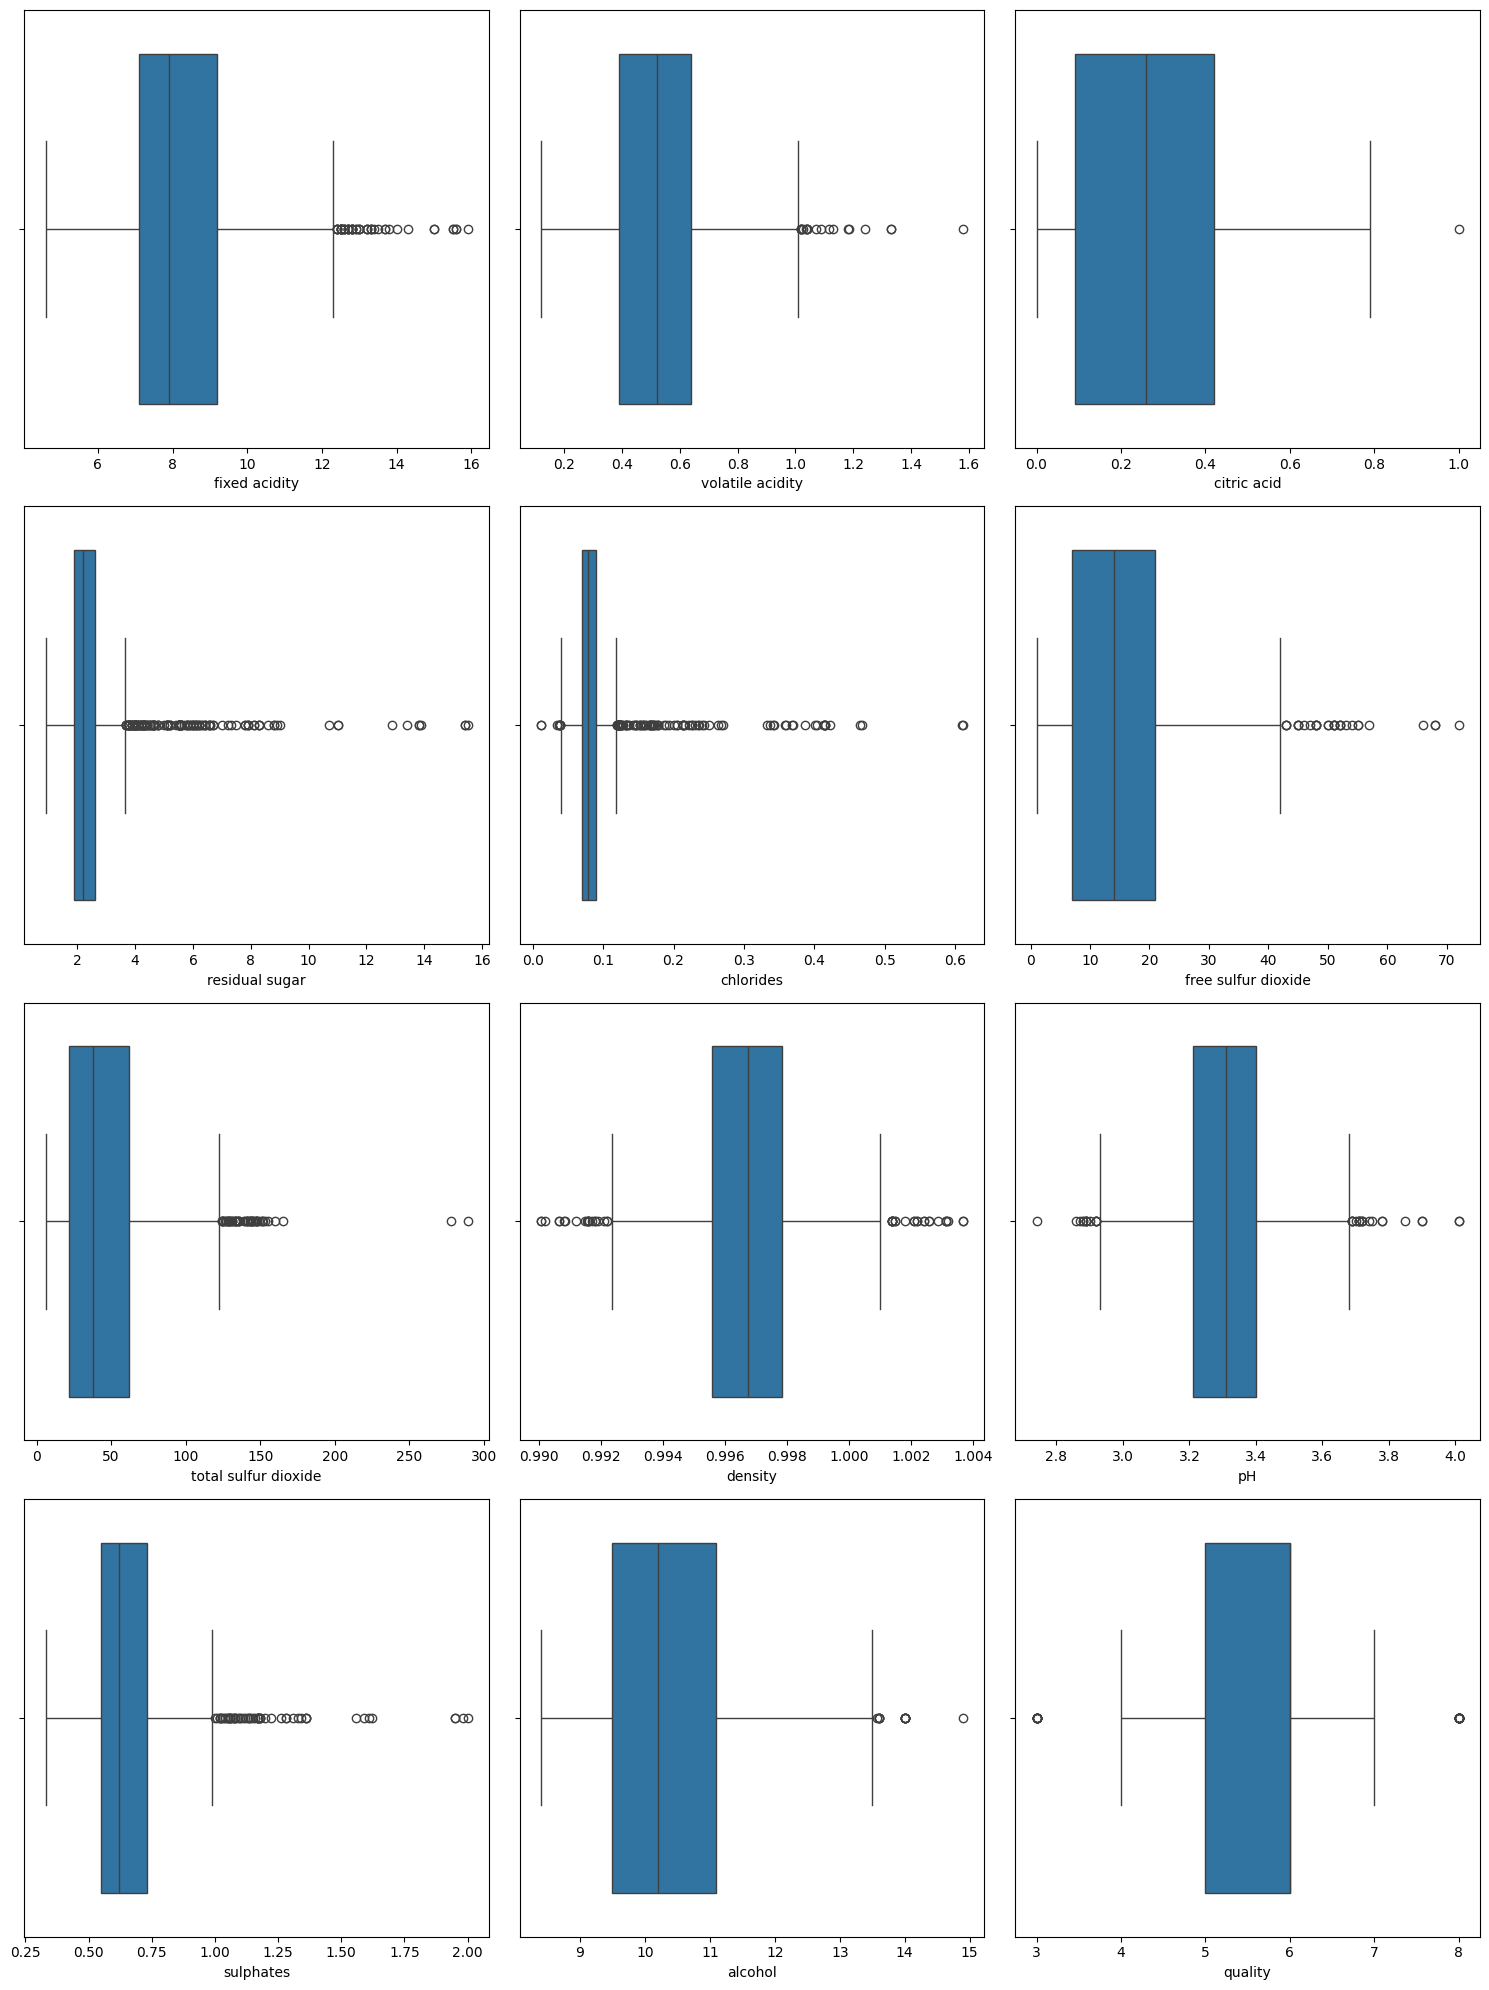

In [ ]:
# Visualize outliers in the data using boxplots for each feature
num_cols = len(dataset_path.columns)
rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate rows needed for 3 columns per row
fig, ax = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Adjust figure size based on rows

# Flatten the 'ax' array and plot each column's boxplot
ax = ax.flatten()
for i, col in enumerate(dataset_path.columns):
    sns.boxplot(data=dataset_path, x=col, ax=ax[i])  # Create a boxplot for each column

# Remove extra subplots, if any
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Handle outliers (IQR method)
Q1 = dataset_path.quantile(0.25) # First quartile
Q3 = dataset_path.quantile(0.75) # Third quartile
IQR = Q3 - Q1 # Interquartile Range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows with outliers beyond the lower or upper bounds
dataset_path = dataset_path[
    ~((dataset_path < lower_bound) | (dataset_path > upper_bound)).any(axis=1)
]

In [ ]:
dataset_path.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1179 non-null   float64
 1   volatile acidity      1179 non-null   float64
 2   citric acid           1179 non-null   float64
 3   residual sugar        1179 non-null   float64
 4   chlorides             1179 non-null   float64
 5   free sulfur dioxide   1179 non-null   float64
 6   total sulfur dioxide  1179 non-null   float64
 7   density               1179 non-null   float64
 8   pH                    1179 non-null   float64
 9   sulphates             1179 non-null   float64
 10  alcohol               1179 non-null   float64
 11  quality               1179 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 119.7 KB


In [ ]:
# Power Iteration function to find the largest eigenvalue and eigenvector
def power_iteration(matrix, num_iter=100):
    n = matrix.shape[1] # Number of columns (dimensions)
    vector = np.random.rand(n)  # Random initial vector
    for _ in range(num_iter):
        b_k1 = np.dot(matrix, vector)  # Matrix-vector multiplication
        b_k1_norm = np.linalg.norm(b_k1)  # Normalize the vector
        vector = b_k1 / b_k1_norm
    eigenvalue = np.dot(vector, np.dot(matrix, vector)) # Largest eigenvalue
    eigenvector = vector # Corresponding eigenvector
    return eigenvalue, eigenvector

In [ ]:
# Compute eigenvalues and eigenvectors using Power Iteration and Deflation
def compute_eigen_decomposition(matrix, num_components):
    covariance_matrix = np.cov(matrix, rowvar=False) # Compute covariance matrix
    eigenvalues = []
    eigenvectors = []

    for _ in range(num_components):
        # Use Power Iteration to find the largest eigenvalue and its eigenvector
        eigenvalue, eigenvector = power_iteration(covariance_matrix)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        # Deflate the covariance matrix to find the next eigenvector
        outer_product = np.outer(eigenvector, eigenvector) * eigenvalue
        covariance_matrix -= outer_product

    return np.array(eigenvalues), np.array(eigenvectors).T

In [ ]:
# Perform PCA for dimensionality reduction
def perform_pca(matrix, num_components):
    mean = np.mean(matrix, axis=0) # Calculate mean for normalization
    std_dev = np.std(matrix, axis=0) # Calculate standard deviation for normalization
    standardized_matrix = (matrix - mean) / std_dev # Normalize the data

    # Use eigen decomposition to compute principal components
    eigenvalues, eigenvectors = compute_eigen_decomposition(standardized_matrix, num_components)

    # Return top k eigenvectors and the mean image
    return eigenvectors[:, :num_components], eigenvalues, mean

In [ ]:
# Calculate reconstruction error after dimensionality reduction
def calculate_reconstruction_error(matrix, q_matrix, mean_vector):
    reduced_data = np.dot(matrix - mean_vector, q_matrix)
    reconstructed_data = np.dot(reduced_data, q_matrix.T) + mean_vector  # Reconstruct original data
    reconstruction_error = np.mean((matrix - reconstructed_data)**2)
    return reconstruction_error

In [ ]:
# Function to print PCA results
def print_results(num_components, reconstruction_error, q_matrix, eigenvalues):
    print(f"Results for k={num_components}:")
    print(f"  Reconstruction Error: {reconstruction_error:.4f}")

    # Printing the eigenvectors (Q matrix)
    print(f"  Eigenvectors (Q Matrix) for k={num_components}:")
    print(q_matrix)

    # Printing the eigenvalues
    print(f"  Eigenvalues:")
    print(eigenvalues)

Results for k=1:
  Reconstruction Error: 0.5036
  Eigenvectors (Q Matrix) for k=1:
[[ 0.5212952 ]
 [-0.30167124]
 [ 0.48256009]
 [ 0.1914058 ]
 [ 0.16492315]
 [-0.07447479]
 [-0.0175745 ]
 [ 0.34811744]
 [-0.40152957]
 [ 0.18643183]
 [-0.01883236]
 [ 0.13102338]]
  Eigenvalues:
[2.96472883]


Results for k=2:
  Reconstruction Error: 0.4793
  Eigenvectors (Q Matrix) for k=2:
[[ 0.52129517  0.05406147]
 [-0.30167138  0.31265   ]
 [ 0.48256014 -0.13085525]
 [ 0.19140573  0.15610172]
 [ 0.164923    0.34659067]
 [-0.07447484  0.10402848]
 [-0.01757463  0.29318496]
 [ 0.34811727  0.38071537]
 [-0.40152955 -0.0526533 ]
 [ 0.18643195 -0.27039955]
 [-0.01883215 -0.47941505]
 [ 0.13102357 -0.43618893]]
  Eigenvalues:
[2.96472883 2.56525771]


Results for k=3:
  Reconstruction Error: 0.3334
  Eigenvectors (Q Matrix) for k=3:
[[ 0.52129518  0.05406133 -0.11368646]
 [-0.3016713   0.31265008 -0.13429087]
 [ 0.48256011 -0.13085538  0.06432768]
 [ 0.19140576  0.15610167  0.24632015]
 [ 0.16492308  0.3

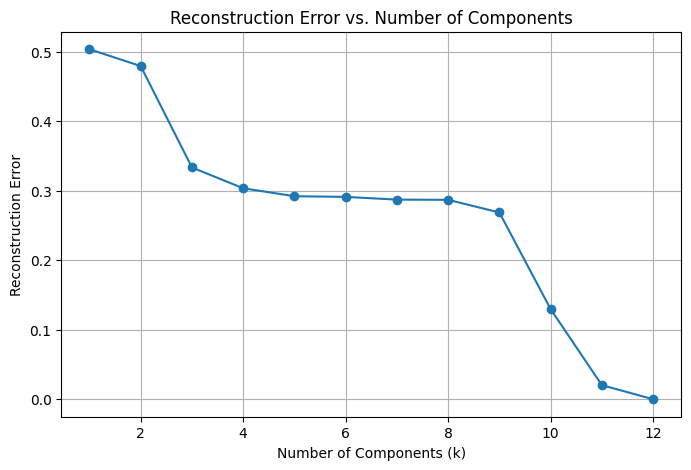

In [ ]:
# Main execution block
if __name__ == "__main__":
    features = dataset_path.values
    # List of dimensions to test from k=1 to max_components
    max_components = min(features.shape[1], 12)
    reconstruction_errors = []

    # Perform PCA for each component count
    for num_components in range(1, max_components + 1):
        # Perform PCA
        q_matrix, eigenvalues, mean_vector = perform_pca(features, num_components)

        # Calculate reconstruction error
        reconstruction_error = calculate_reconstruction_error(features, q_matrix, mean_vector)

        # Append reconstruction error for plotting later
        reconstruction_errors.append(reconstruction_error)

        # Print results
        print_results(num_components, reconstruction_error, q_matrix, eigenvalues)
        print("\n")

    # Plot reconstruction error across different k values
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_components + 1), reconstruction_errors, marker='o')
    plt.xlabel("Number of Components (k)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error vs. Number of Components")
    plt.grid(True)
    plt.show()

In [ ]:
# Function to find neighbors within a given radius for DBSCAN clustering
def find_neighbors(data, point_idx, eps):
  distances = []
  for row in data:
      distance = np.sqrt(np.sum((row - data[point_idx]) ** 2)) # Compute Euclidean distance
      distances.append(distance)

  distances = np.array(distances)
  return np.where(distances <= eps)[0] # Return indices of neighbors within 'eps'

In [ ]:
# DBSCAN implementation
def dbscan(data, eps, min_samples):
    # Initialize labels with -1 (indicating noise)
    labels = np.zeros(len(data)) - 1
    cluster_label = 0  # Initialize cluster labels

    for i in range(len(data)):
        # Skip the point if it is already labeled
        if labels[i] != -1:
            continue

        # Find neighbors within the 'eps' radius
        neighbors = find_neighbors(data, i, eps)

        # If the number of neighbors is less than 'min_samples', mark the point as noise
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            # Assign a new cluster label
            cluster_label += 1
            labels[i] = cluster_label

            # Expand the cluster by iterating through its neighbors
            for j in neighbors:
                if labels[j] == -1:  # If the point is noise, include it in the cluster
                    labels[j] = cluster_label

                    # Find the neighbors of the current point
                    new_neighbors = find_neighbors(data, j, eps)

                    # If the new neighbors meet the density condition, add them to the neighbors list
                    if len(new_neighbors) >= min_samples:
                        neighbors = np.concatenate((neighbors, new_neighbors))

    return labels


In [ ]:
# Function to print DBSCAN results
def print_results_dbscan(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)

    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise
    n_noise = np.sum(labels == -1)


    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print("\nCluster Sizes:")

    for label, count in zip(unique_labels, counts):
        if label == -1:
            print(f"Noise Point Count: {count}")
        else:
            print(f"Cluster {label}: {count} points")


DBSCAN results:
Number of clusters: 65
Number of noise points: 108

Cluster Sizes:
Noise Point Count: 108
Cluster 1.0: 75 points
Cluster 2.0: 23 points
Cluster 3.0: 21 points
Cluster 4.0: 17 points
Cluster 5.0: 48 points
Cluster 6.0: 42 points
Cluster 7.0: 94 points
Cluster 8.0: 14 points
Cluster 9.0: 2 points
Cluster 10.0: 14 points
Cluster 11.0: 32 points
Cluster 12.0: 47 points
Cluster 13.0: 125 points
Cluster 14.0: 18 points
Cluster 15.0: 19 points
Cluster 16.0: 21 points
Cluster 17.0: 31 points
Cluster 18.0: 14 points
Cluster 19.0: 11 points
Cluster 20.0: 60 points
Cluster 21.0: 11 points
Cluster 22.0: 8 points
Cluster 23.0: 16 points
Cluster 24.0: 19 points
Cluster 25.0: 36 points
Cluster 26.0: 9 points
Cluster 27.0: 15 points
Cluster 28.0: 7 points
Cluster 29.0: 6 points
Cluster 30.0: 18 points
Cluster 31.0: 8 points
Cluster 32.0: 14 points
Cluster 33.0: 5 points
Cluster 34.0: 10 points
Cluster 35.0: 20 points
Cluster 36.0: 11 points
Cluster 37.0: 2 points
Cluster 38.0: 15 poin

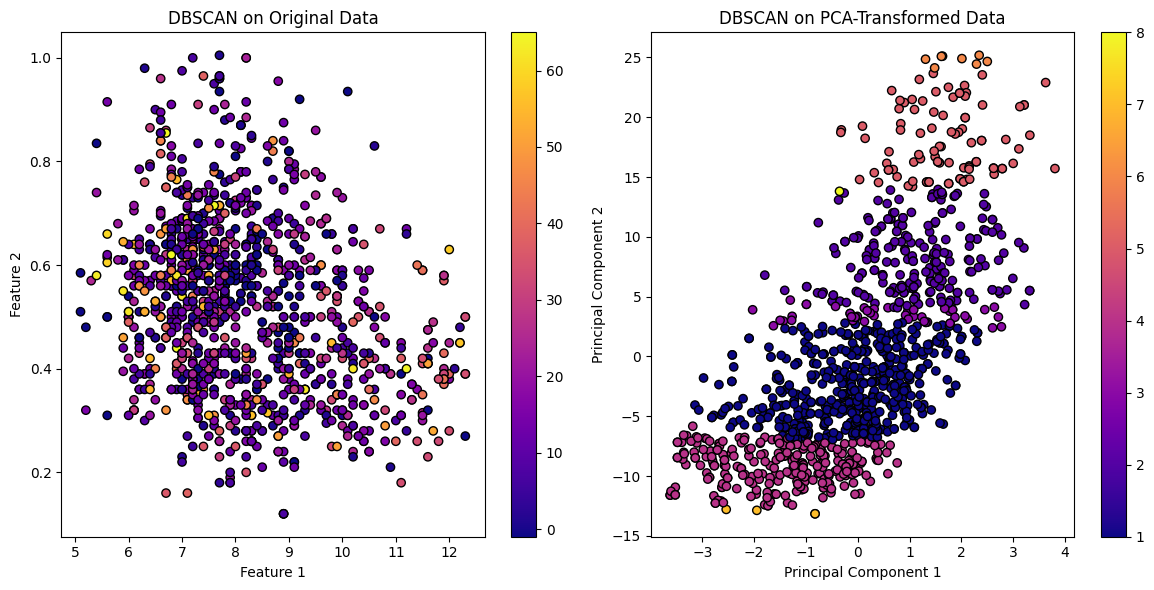

In [ ]:
# DBSCAN parameters (adjust as needed)
eps = 5
min_samples = 10

# DBSCAN before PCA
original_labels = dbscan(features, eps, min_samples)
print ("\nDBSCAN results:")
print_results_dbscan(original_labels)


# Apply DBSCAN after PCA
num_components = 2  # Use 2 principal components
q_matrix, eigenvalues, mean_vector = perform_pca(dataset_path.values, num_components) # Project data to 2D PCA space

#DBSCAN After Apply PCA
X_pca = np.dot(dataset_path.values - mean_vector, q_matrix)
pca_labels = dbscan(X_pca, eps, min_samples)
print ("\nDBSCAN results After PCA: ")
print_results_dbscan(pca_labels)

# Visualize clustering results before and after PCA
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#Original Data
scatter1 = axes[0].scatter(features[:, 0], features[:, 1], c=original_labels , cmap='plasma', marker='o', edgecolor='k')
axes[0].set_title('DBSCAN on Original Data')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=axes[0])

# After Apply PCA
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=pca_labels , cmap='plasma', marker='o', edgecolor='k')
axes[1].set_title('DBSCAN on PCA-Transformed Data')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()
